In [1]:
import tensorcraft as tc
import numpy as np
import matplotlib.pyplot as plt


{Token('TENSORVAR', 'X'): Token('TENSORVAR', 'X'), Token('TENSORVAR', 'C'): Token('TENSORVAR', 'C'), Token('TENSORVAR', 'D'): 'D[j,k] = (X[j,l] - C[k,l]) * (X[j,l] - C[k,l])'}
{Token('TENSORVAR', 'X'): Token('TENSORVAR', 'X'), Token('TENSORVAR', 'C'): Token('TENSORVAR', 'C'), Token('TENSORVAR', 'D'): 'D[j,k] = (X[j,l] - C[k,l]) * (X[j,l] - C[k,l])', Token('TENSORVAR', 'M'): 'M[j] = 1000'}
{Token('TENSORVAR', 'X'): Token('TENSORVAR', 'X'), Token('TENSORVAR', 'C'): Token('TENSORVAR', 'C'), Token('TENSORVAR', 'D'): 'D[j,k] = (X[j,l] - C[k,l]) * (X[j,l] - C[k,l])', Token('TENSORVAR', 'M'): 'M[j] = 1000', Token('TENSORVAR', 'Y'): 'Y[j] = -1'}
{Token('TENSORVAR', 'X'): Token('TENSORVAR', 'X'), Token('TENSORVAR', 'C'): Token('TENSORVAR', 'C'), Token('TENSORVAR', 'D'): 'D[j,k] = (X[j,l] - C[k,l]) * (X[j,l] - C[k,l])', Token('TENSORVAR', 'M'): 'M[j] = (D[j,k] < M[j]) * (D[j,k] - M[j])', Token('TENSORVAR', 'Y'): 'Y[j] = -1'}
{Token('TENSORVAR', 'X'): Token('TENSORVAR', 'X'), Token('TENSORVAR', '

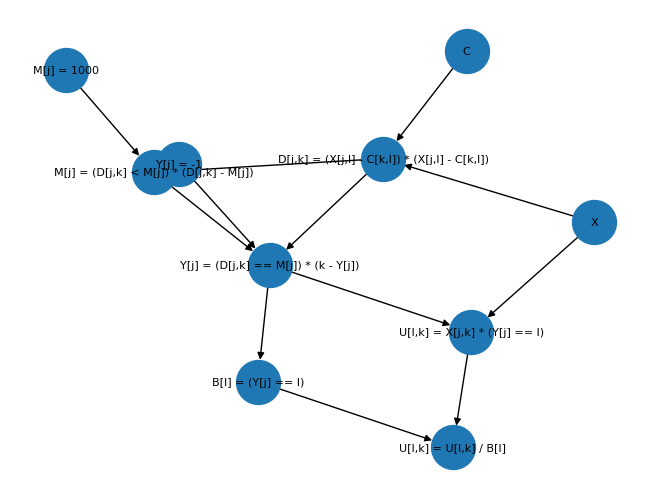

In [2]:
import importlib
import matplotlib.pyplot as plt
import networkx as nx

importlib.reload(tc)
from tensorcraft.compiler.compiler import DataGraphTransformer
code = """
# Distance computation
D[j,k] = (X[j,l] - C[k,l]) * (X[j,l] - C[k,l])

# Argmin
M[j] = 1000
Y[j] = -1
M[j] = (D[j,k] < M[j]) * (D[j,k] - M[j])
Y[j] = (D[j,k] == M[j]) * (k - Y[j])

# Cluster update
B[l] = (Y[j] == l)
U[l,k] = X[j,k] * (Y[j] == l)
U[l,k] = U[l,k] / B[l]
"""
tree = tc.compile(code)

dataGraph = DataGraphTransformer(code).transform(tree)
# pos = nx.drawing.bfs_layout(dataGraph, "X", align="vertical")
nx.draw_kamada_kawai(dataGraph, with_labels=True, font_size=8, node_size=1000)

{Token('TENSORVAR', 'A'): Token('TENSORVAR', 'A'), Token('TENSORVAR', 'G_c'): Token('TENSORVAR', 'G_c'), Token('TENSORVAR', 'D_c'): Token('TENSORVAR', 'D_c'), Token('TENSORVAR', 'X_c'): Token('TENSORVAR', 'X_c'), Token('TENSORVAR', 'W_c'): 'W_c[i] = A[i,j] * D_c[j]'}
{Token('TENSORVAR', 'A'): Token('TENSORVAR', 'A'), Token('TENSORVAR', 'G_c'): Token('TENSORVAR', 'G_c'), Token('TENSORVAR', 'D_c'): Token('TENSORVAR', 'D_c'), Token('TENSORVAR', 'X_c'): Token('TENSORVAR', 'X_c'), Token('TENSORVAR', 'W_c'): 'W_c[i] = A[i,j] * D_c[j]', Token('TENSORVAR', 'Gamma_c'): 'Gamma_c = G_c[i] * G_c[i]'}
{Token('TENSORVAR', 'A'): Token('TENSORVAR', 'A'), Token('TENSORVAR', 'G_c'): Token('TENSORVAR', 'G_c'), Token('TENSORVAR', 'D_c'): Token('TENSORVAR', 'D_c'), Token('TENSORVAR', 'X_c'): Token('TENSORVAR', 'X_c'), Token('TENSORVAR', 'W_c'): 'W_c[i] = A[i,j] * D_c[j]', Token('TENSORVAR', 'Gamma_c'): 'Gamma_c = G_c[i] * G_c[i]', Token('TENSORVAR', 'Theta_c'): 'Theta_c = D_c[i] * W_c[i]'}
{Token('TENSORVA

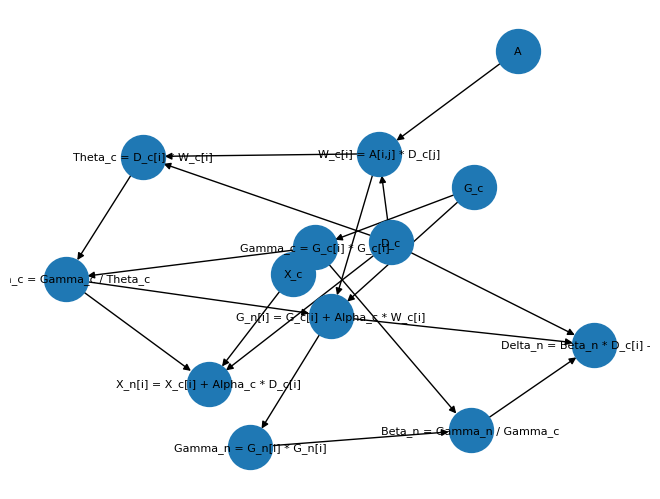

In [3]:

import importlib
import matplotlib.pyplot as plt
import networkx as nx

importlib.reload(tc)
from tensorcraft.compiler.compiler import DataGraphTransformer
code = """
W_c[i] = A[i,j] * D_c[j]
Gamma_c = G_c[i] * G_c[i]
Theta_c = D_c[i] * W_c[i]

Alpha_c = Gamma_c / Theta_c
X_n[i] = X_c[i] + Alpha_c * D_c[i]
G_n[i] = G_c[i] + Alpha_c * W_c[i]

Gamma_n = G_n[i] * G_n[i]
Beta_n = Gamma_n / Gamma_c
Delta_n = Beta_n * D_c[i] - G_n[i]
"""
tree = tc.compile(code)

dataGraph = DataGraphTransformer(code).transform(tree)
# pos = nx.drawing.bfs_layout(dataGraph, "X", align="vertical")
nx.draw_kamada_kawai(dataGraph, with_labels=True, font_size=8, node_size=1000)